# First level analysis with Nipype + SPM

In [1]:
from nipype.interfaces import spm
from nilearn.datasets import fetch_spm_auditory
from nilearn.plotting import plot_anat, plot_img, plot_stat_map
from nilearn.image import concat_imgs, mean_img
from nipype import Workflow
import pandas as pd
import os

ModuleNotFoundError: No module named 'nilearn'

## Set necessary paths (not necessary when using a Dockerfile generated from Neurodocker

In [2]:
#import nipype.interfaces.matlab as mlab
#mlab.MatlabCommand.set_default_matlab_cmd('/opt/matlab/R2022a/bin/matlab')
# mlab.MatlabCommand.set_default_paths('/opt/matlab/toolboxes/spm12')

In [3]:
from nipype.interfaces import spm
spm.SPMCommand.set_mlab_paths(matlab_cmd='/opt/matlab/R2022a/bin/matlab', paths='/opt/matlab/toolboxes/spm12', use_mcr=False)
spm.SPMCommand().version

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


'12.7771'

## Get the current working directory of this script

In [4]:
working_directory = os.getcwd()
working_directory

'/home/johannes.wiesner/work/repos/workshop_cimh/workshop/courses/nipype'

## Download the dataset

In [5]:
subject_data = fetch_spm_auditory(data_dir=os.path.join(working_directory,'data'))

## Plot the first 3D image of the time series

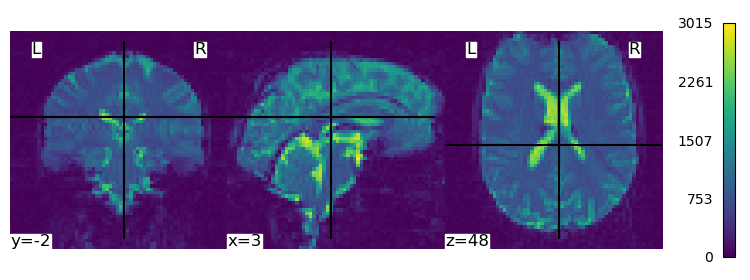

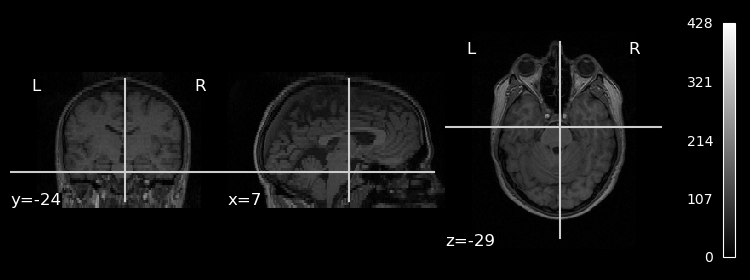

In [6]:
plot_img(subject_data.func[0], colorbar=True, cbar_tick_format="%i")
plot_anat(subject_data.anat, colorbar=True, cbar_tick_format="%i")

## Concatenate the images to one 4D file 

In [7]:
fmri_img = concat_imgs(subject_data.func)
filepath = os.path.join(working_directory,'data/fmri_img.nii')
fmri_img.to_filename(filepath)

## Let's also get the events

In [8]:
events = pd.read_table(subject_data["events"])
events['amplitude'] = 1
events_full_path = os.path.join(os.getcwd(),'data/events.tsv')
events.to_csv(events_full_path,sep='\t',index=False)
events

,onset,duration,trial_type,amplitude
0,0.0,42.0,rest,1
1,42.0,42.0,active,1
2,84.0,42.0,rest,1
3,126.0,42.0,active,1
4,168.0,42.0,rest,1
5,210.0,42.0,active,1
6,252.0,42.0,rest,1
7,294.0,42.0,active,1
8,336.0,42.0,rest,1
9,378.0,42.0,active,1


## Use Nipype & SPM to conduct a first level analysis

In [9]:
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node

## Specify everything that SPM needs

In [10]:
model_specifier = Node(SpecifySPMModel(concatenate_runs=False,
                                       input_units='secs',
                                       output_units='secs',
                                       time_repetition=7,
                                       high_pass_filter_cutoff=128,
                                       functional_runs = [filepath],
                                       bids_event_file = [events_full_path]
                                      ),
                       name='model_specifier')

# Level1Design - Generates an SPM design matrix
# We use the FAST method to correct for autocorrelations (see https://www.nature.com/articles/s41467-019-09230-w)
first_level_design = Node(Level1Design(bases={'hrf':{'derivs': [0,0]}},
                                       interscan_interval=7,
                                       timing_units='secs',
                                       model_serial_correlations='FAST'),
                          name='first_level_design')

# EstimateModel - estimate the parameters of the model
first_level_estimator = Node(EstimateModel(estimation_method={'Classical': 1}),name='first_level_estimator')

## EstimateContrast - estimate contrasts
contrast_1 = ('Active > Rest','T', ['active','rest'],[1,-1])
contrast_2 = ('Rest > Active','T', ['active','rest'],[-1,1])
first_level_contrasts = Node(EstimateContrast(), name='first_level_contrasts')
first_level_contrasts.inputs.contrasts = [contrast_1,contrast_2]

## Connect all nodes to a Workflow

In [11]:
# define workflow
wf = Workflow(name='first_level_analysis',base_dir='./')
wf.connect(model_specifier,'session_info',first_level_design,'session_info')
wf.connect(first_level_design,'spm_mat_file',first_level_estimator,'spm_mat_file')
wf.connect(first_level_estimator,'spm_mat_file',first_level_contrasts,'spm_mat_file')
wf.connect(first_level_estimator,'beta_images',first_level_contrasts,'beta_images')
wf.connect(first_level_estimator,'residual_image',first_level_contrasts,'residual_image')
wf.run()

230420-14:43:11,275 nipype.workflow INFO:
	 Workflow first_level_analysis settings: ['check', 'execution', 'logging', 'monitoring']
230420-14:43:11,278 nipype.workflow INFO:
	 Running serially.
230420-14:43:11,279 nipype.workflow INFO:
	 [Node] Setting-up "first_level_analysis.model_specifier" in "/home/johannes.wiesner/work/repos/workshop_cimh/workshop/courses/nipype/first_level_analysis/model_specifier".
230420-14:43:11,280 nipype.workflow INFO:
	 [Node] Outdated cache found for "first_level_analysis.model_specifier".
230420-14:43:11,282 nipype.workflow INFO:
	 [Node] Executing "model_specifier" <nipype.algorithms.modelgen.SpecifySPMModel>
230420-14:43:11,284 nipype.workflow INFO:
	 [Node] Finished "model_specifier", elapsed time 0.000674s.
230420-14:43:11,286 nipype.workflow INFO:
	 [Node] Setting-up "first_level_analysis.first_level_design" in "/home/johannes.wiesner/work/repos/workshop_cimh/workshop/courses/nipype/first_level_analysis/first_level_design".
230420-14:43:11,287 nipyp

stty: 'standard input': Inappropriate ioctl for device


230420-14:43:31,362 nipype.workflow INFO:
	 [Node] Finished "first_level_design", elapsed time 13.1177s.
230420-14:43:31,365 nipype.workflow INFO:
	 [Node] Setting-up "first_level_analysis.first_level_estimator" in "/home/johannes.wiesner/work/repos/workshop_cimh/workshop/courses/nipype/first_level_analysis/first_level_estimator".
230420-14:43:31,370 nipype.workflow INFO:
	 [Node] Executing "first_level_estimator" <nipype.interfaces.spm.model.EstimateModel>


stty: 'standard input': Inappropriate ioctl for device


230420-14:43:47,825 nipype.workflow INFO:
	 [Node] Finished "first_level_estimator", elapsed time 16.454211s.
230420-14:43:47,828 nipype.workflow INFO:
	 [Node] Setting-up "first_level_analysis.first_level_contrasts" in "/home/johannes.wiesner/work/repos/workshop_cimh/workshop/courses/nipype/first_level_analysis/first_level_contrasts".
230420-14:43:47,832 nipype.workflow INFO:
	 [Node] Executing "first_level_contrasts" <nipype.interfaces.spm.model.EstimateContrast>


stty: 'standard input': Inappropriate ioctl for device


230420-14:44:00,145 nipype.workflow INFO:
	 [Node] Finished "first_level_contrasts", elapsed time 12.311932s.


stty: 'standard input': Inappropriate ioctl for device


## Plot the workflow

In [12]:
# Create 1st-level analysis output graph
wf.write_graph()
from IPython.display import Image
Image(filename='./first_level_analysis/graph.png')

230420-14:44:00,333 nipype.workflow INFO:
	 Generated workflow graph: ./first_level_analysis/graph.png (graph2use=hierarchical, simple_form=True).


'./first_level_analysis/graph.png'

# Plot the statistical image

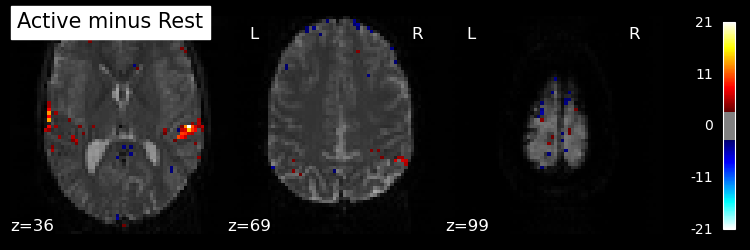

In [14]:
# Plot the image
from nilearn.image import load_img
from nilearn.image import mean_img
from nilearn.plotting import plot_stat_map

# create a background image
mean_img = mean_img(fmri_img)

# load the contrast image
contrast_img = load_img('./first_level_analysis/first_level_contrasts/spmT_0001.nii')

plot_stat_map(stat_map_img=contrast_img,
              bg_img=mean_img,
              threshold=3.0,
              display_mode="z",
              cut_coords=3,
              black_bg=True,
              title="Active minus Rest",
)

## The 'first_level_analysis' folder looks nasty. Can't we make it more pretty?

In [15]:
## Yes we can!
output_directory = os.path.join(working_directory,'output')
os.makedirs('./output',exist_ok=True)

# define a DataSink node where files should be stored
datasink = Node(DataSink(base_directory=output_directory),name="datasink")
wf.connect(first_level_contrasts,'spmT_images',datasink,'spm_contrast_images')
wf.run()

230420-14:44:01,596 nipype.workflow INFO:
	 Workflow first_level_analysis settings: ['check', 'execution', 'logging', 'monitoring']
230420-14:44:01,600 nipype.workflow INFO:
	 Running serially.
230420-14:44:01,600 nipype.workflow INFO:
	 [Node] Setting-up "first_level_analysis.model_specifier" in "/home/johannes.wiesner/work/repos/workshop_cimh/workshop/courses/nipype/first_level_analysis/model_specifier".
230420-14:44:01,602 nipype.workflow INFO:
	 [Node] Cached "first_level_analysis.model_specifier" - collecting precomputed outputs
230420-14:44:01,602 nipype.workflow INFO:
	 [Node] "first_level_analysis.model_specifier" found cached.
230420-14:44:01,602 nipype.workflow INFO:
	 [Node] Setting-up "first_level_analysis.first_level_design" in "/home/johannes.wiesner/work/repos/workshop_cimh/workshop/courses/nipype/first_level_analysis/first_level_design".
230420-14:44:01,604 nipype.workflow INFO:
	 [Node] Cached "first_level_analysis.first_level_design" - collecting precomputed outputs
2

stty: 'standard input': Inappropriate ioctl for device


# I always can't remember what the numbers in T_xxxx stand for...

230420-15:01:55,613 nipype.workflow INFO:
	 Workflow first_level_analysis settings: ['check', 'execution', 'logging', 'monitoring']
230420-15:01:55,617 nipype.workflow INFO:
	 Running serially.
230420-15:01:55,618 nipype.workflow INFO:
	 [Node] Setting-up "first_level_analysis.model_specifier" in "/home/johannes.wiesner/work/repos/workshop_cimh/workshop/courses/nipype/first_level_analysis/model_specifier".
230420-15:01:55,619 nipype.workflow INFO:
	 [Node] Cached "first_level_analysis.model_specifier" - collecting precomputed outputs
230420-15:01:55,620 nipype.workflow INFO:
	 [Node] "first_level_analysis.model_specifier" found cached.
230420-15:01:55,620 nipype.workflow INFO:
	 [Node] Setting-up "first_level_analysis.first_level_design" in "/home/johannes.wiesner/work/repos/workshop_cimh/workshop/courses/nipype/first_level_analysis/first_level_design".
230420-15:01:55,622 nipype.workflow INFO:
	 [Node] Cached "first_level_analysis.first_level_design" - collecting precomputed outputs
2

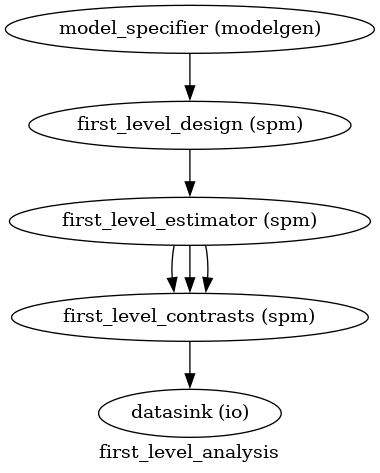

In [18]:
# define a DataSink node where files should be stored
datasink = Node(DataSink(base_directory=output_directory,substitutions=[('spmT_0001.nii','active_greater_rest.nii'),('spmT_0002.nii','rest_greater_active.nii')]),name="datasink")
wf = Workflow(name='first_level_analysis',base_dir='./')
wf.connect(model_specifier,'session_info',first_level_design,'session_info')
wf.connect(first_level_design,'spm_mat_file',first_level_estimator,'spm_mat_file')
wf.connect(first_level_estimator,'spm_mat_file',first_level_contrasts,'spm_mat_file')
wf.connect(first_level_estimator,'beta_images',first_level_contrasts,'beta_images')
wf.connect(first_level_estimator,'residual_image',first_level_contrasts,'residual_image')
wf.connect(first_level_contrasts,'spmT_images',datasink,'spm_contrast_images')
wf.run()